In [2]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi
import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [4]:
# HIDDEN
times = pd.read_csv('ilec.csv')['17.5']

## The Studentized Bootstrap



The **bootstrap** is a process we learned about in Data 8 that we can use for estimating a population statistic using only one sample. The general procedure for bootstrapping is as follows:
- Draw a sizable sample from the population.
- Using this sample, we *resample with replacement* to form new samples of the same size.
- We do this many times, taking the desired statistic of each resample (e.g. we take the median of each resample).

Here, we end up with many test statistics from individual resamples, from which we can form a distribution. In Data 8, we were taught to form a 95% confidence interval by taking the 2.5th percentile and the 97.5th percentile of the bootstrap statistics. This method of bootstrapping to create a confidence interval is called the **percentile bootstrap.** 95% confidence implies that if we take a new sample from the population and construct a confidence interval, the confidence interval will contain the population parameter with probability 0.95. However, it is important to note that confidence intervals created from real data can only approximate 95% confidence. The percentile bootstrap in particular has lower confidence than desired at small sample sizes.

Below, we've taken a population and created one thousand bootstrap 95% confidence intervals for the population mean for different sample sizes. The y-axis represents the fraction of the one thousand confidence intervals that contained the real population mean. Notice that at sample sizes below 20, fewer than 90% of the confidence intervals actually contain the population mean.

<img src="../../assets/coverage_percentile_bootstrap.png"></img>

We can measure *coverage error* by calculating the difference between our measured confidence here and our desired 95% confidence. We can see that the coverage error for percentile bootstrap is very high at small sample sizes. In this chapter, we will introduce a new bootstrap method, called the **studentized bootstrap** method, that has a lower coverage error but requires more computation.

### Repair Times

The New York Public Utilities Commission monitors the response time for repairing land-line phone service in the state. These repair times may differ over the year and according to the type of repair. We have a census of repair times for one class of repairs at one time period for a specific *Incumbent Local Exchange Carrier*, which is a telephone company which held the regional monopoly on landline service before the market was opened to competitive local exchange carriers, or the corporate successor of such a firm. The commission is interested in estimates of the average repair time. First, let's look at a distribution of all of the times.

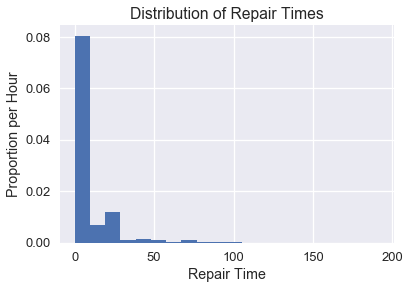

In [5]:
plt.hist(times, bins=20, normed=True)
plt.xlabel('Repair Time')
plt.ylabel('Proportion per Hour')
plt.title('Distribution of Repair Times');

Let's say we want to estimate the population mean of the repair times. We first need to define the main statistic function needed to do this. By passing in the whole population, we can see that actual average repair time is about 8.4 hours.

In [6]:
def stat(sample, axis=None):
    return np.mean(sample, axis=axis)

In [7]:
theta = stat(times)
theta

8.406145520144333

Now we need to define a method that will return a list of indices so we can resample from the original sample without replacement.

In [8]:
def take_sample(n=10):
    return np.random.choice(times, size=n, replace=False)

In real life, we won't be able to draw many samples from the population (we use bootstrap to be able to use just one sample). But for demonstration purposes, we have access to the entire population, so we will take 1000 samples of size 10 and plot the distribution of the sample means.

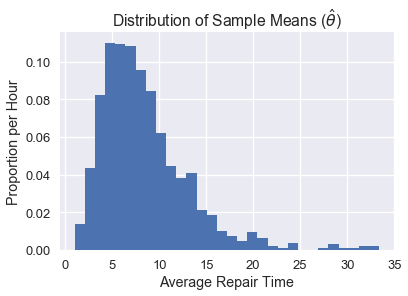

In [9]:
samples_from_pop = 1000

pop_sampling_dist = np.array(
    [stat(take_sample()) for _ in range(samples_from_pop)]
)

plt.hist(pop_sampling_dist, bins=30, normed=True);
plt.xlabel('Average Repair Time')
plt.ylabel('Proportion per Hour')
plt.title(r'Distribution of Sample Means ($\hat{\theta}$)');

We can see that the center of this distribution is ~5, and that it is skewed right because of the skewed distribution of the original data. 

### Comparing Distributions of the Statistic

Now we can look at how a single bootstrap distribution can stack up against a distribution sampled from the population. 

Generally, we are aiming to estimate $\theta^*$, our population parameter (in this case, the average repair time of the population, which we found to be ~8.4). Each individual sample can be used to calculate an estimated statistic, $\hat\theta$ (in this case, the average repair time of a single sample). The plot above shows what we call an *empirical distribution* of $\hat\theta$, which is calculated of many estimated statistics from many samples from the population. For the bootstrap, however, we want the statistic of the resample of the original sample, which is called $\tilde\theta$. 

In order for the bootstrap to work, we want our original sample to look similar to the population, so that resamples also look similar to the population. If our original sample *does* look like the population, then the distribution of average repair times calculated from the resamples will look similar to the empirical distribution of samples directly from the population.

Let's take a look at how an individual bootstrap distribution will look. We can define methods to take samples of size 10 without replacement and bootstrap it 1000 times to get our distribution.

In [10]:
bootstrap_reps = 1000

def resample(sample, reps):
    n = len(sample)
    return np.random.choice(sample, size=reps * n).reshape((reps, n))

def bootstrap_stats(sample, reps=bootstrap_reps, stat=stat):
    resamples = resample(sample, reps)
    return stat(resamples, axis=1)

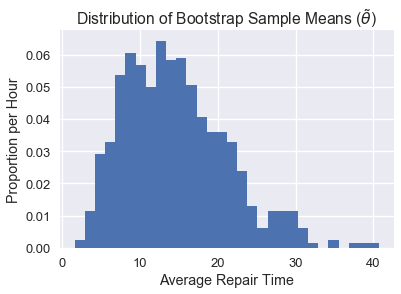

In [11]:
np.random.seed(0)

sample = take_sample()

plt.hist(bootstrap_stats(sample), bins=30, normed=True)
plt.xlabel('Average Repair Time')
plt.ylabel('Proportion per Hour')
plt.title(r'Distribution of Bootstrap Sample Means ($\tilde{\theta}$)');

As you can see, our distribution of $\tilde\theta$ doesn't look *quite* like the distribution of $\hat\theta$, likely because our original sample did not look like the population. As a result, our confidence intervals perform rather poorly. Below we can see a side-by-side comparison of the two distributions:

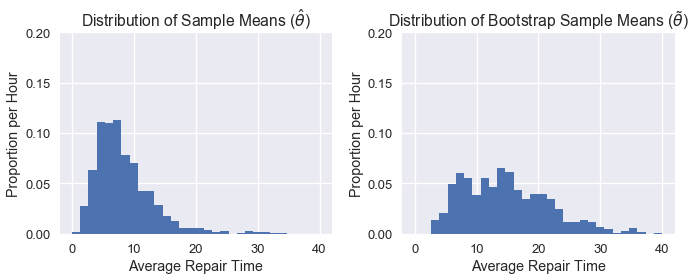

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.xlabel('Average Repair Time')
plt.ylabel('Proportion per Hour')
plt.title(r'Distribution of Sample Means ($\hat{\theta}$)')
plt.hist(pop_sampling_dist, bins=30, range=(0, 40), normed=True)
plt.ylim((0,0.2))

plt.subplot(122)
plt.xlabel('Average Repair Time')
plt.ylabel('Proportion per Hour')
plt.title(r'Distribution of Bootstrap Sample Means ($\tilde{\theta}$)')
plt.hist(bootstrap_stats(sample), bins=30, range=(0, 40), normed=True)
plt.ylim((0,0.2))

plt.tight_layout();

### The Studentized Bootstrap Procedure

As we saw, the main issue with percentile bootstrap procedure is that it takes a larger sample size to really reach the desired 95% confidence. With the studentized bootstrap procedure, we can do a little more calculation to get better coverage at smaller sample sizes.

The idea behind the studentized bootstrap procedure is to normalize the distribution of the test statistic $\tilde\theta$ to be centered at 0 and have a standard deviation of 1. This will correct for the spread difference and skew of the original distribution. In order to do all of this, we need to do some derivation first.

In the percentile bootstrap procedure, we generate many values of $\tilde\theta$, and then we take the 2.5th and 97.5th percentiles for our confidence interval. For short, we refer to these percentiles as $q_{2.5}$ and $q_{97.5}$. Note that both of these values come from the bootstrap statistics.

With this procedure, we hope that the probability that the actual population statistic lies between our confidence intervals is about 95%. In other words, we hope for the following equality:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \theta^* \leq q_{97.5}\right)
\end{aligned}
$$

We make two approximations during this procedure: since we assume our random sample looks like the population, we approximate $\theta^*$ with $\hat\theta$; since we assume a random resample looks like the original sample, we approximate $\hat\theta$ with $\tilde\theta$. Since the second approximation relies on the first one, they both introduce error in the confidence interval generation, which creates the coverage error we saw in the plot.

We aim to reduce this error by normalizing our statistic. Instead of using our calculated value of $\tilde\theta$ directly, we use: 

$$
\begin{aligned}
\frac
    {\tilde{\theta} - {\hat{\theta}}}
    {SE({\tilde{\theta}})}
\end{aligned}
$$

This will normalize the resample statistic by the sample statistic, and then divide by the standard deviation of the resample statistic (this standard deviation is also called the standard error, or SE).

This whole normalized statistic is called the Student's t-statistic, so we call this bootstrap method the **studentized bootstrap** or the **bootstrap-t** method.

As usual, we compute this statistic for many resamples, and then take the 2.5th and 97.5th percentiles — $ q_{2.5} $ and $ q_{97.5} $. As such, we hope that the normalized population parameter lies between these percentiles:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \frac{\hat{\theta} - \theta^*} {SE({\hat{\theta}})} \leq q_{97.5}\right) \\
\end{aligned}
$$

We can now solve the inequality for $\theta^*$:

$$
\begin{aligned}
0.95 &= {\cal P}\left(q_{2.5} \leq \frac{\hat{\theta} - \theta^*} {SE({\hat{\theta}})} \leq q_{97.5}\right) \\
 &= {\cal P}\left(q_{2.5}SE({\hat{\theta}}) \leq {\hat{\theta} - \theta^*} \leq q_{97.5}SE({\hat{\theta}})\right) \\
 &= {\cal P}\left(\hat{\theta} - q_{97.5}SE({\hat{\theta}}) \leq {\theta^*} \leq \hat{\theta} - q_{2.5}SE({\hat{\theta}})\right) 
\end{aligned}
$$

This means we can construct our confidence interval using just $\hat\theta$ (the test statistic on the original sample), $q_{2.5}$ and $q_{97.5}$ (the percentiles of the normalized statistic computed with the resamples), and $SE(\hat\theta)$ (the standard deviation of the sample test statistic). This last value is estimated by using the standard deviation of the resample test statistics.

Thus, to compute a studentized bootstrap CI, we perform the following procedure:

1. Compute $ \hat{\theta} $, the test statistic on the sample.
1. Bootstrap the sample a large number of times.
1. For each bootstrap resample:
    1. Compute $ \tilde \theta $, the test statistic on the resample.
    1. Compute $ SE({\tilde{\theta}}) $.
    1. Compute $ q =  \frac{\tilde{\theta} - {\hat{\theta}}}{SE({\tilde{\theta}})} $.
1. Estimate $ SE(\hat \theta) $ using the standard deviation of the $ \tilde \theta $ values.
1. Calculate the confidence intervals thusly: $ \left[ \hat{\theta} - q_{97.5}SE({\hat{\theta}}), \hat{\theta} - q_{2.5}SE({\hat{\theta}}) \right]$.

### Computing the Standard Error of the Resample Statistic

It is important to note that $SE(\hat\theta)$, the standard error of the resample test statistic, is not always easy to compute and is dependent on the test statistic. For the sample mean, $SE(\tilde\theta)=\frac{\tilde\sigma}{\sqrt{n}}$, the standard deviation of the resample values divided by the square root of the sample size. 

Also remember that we have to use the resample values to compute $ SE(\tilde \theta) $; we use the sample values to compute $ SE(\hat \theta) $.

If our test statistic, however, does not have an analytic expression (like the one we have for the sample mean), then we need to do a second-level bootstrap. For each resample, we bootstrap it again, and compute the test statistic on each second-level resample (the resampled resample), and compute the standard deviation using these second-level statistics. Typically, we do around 50 second-level resamples.

This greatly increases computation time for the studentized bootstrap procedure. If we do 50 second-level resamples, the entire procedure will take 50 times as long as if we just had an analytic expression for $SE(\tilde\theta)$.

### Comparison of Studentized Bootstrap with Percentile Bootstrap

To assess the tradeoffs of studentized and percentile bootstrap, let's compare the coverage of the two methods using the repair times dataset.

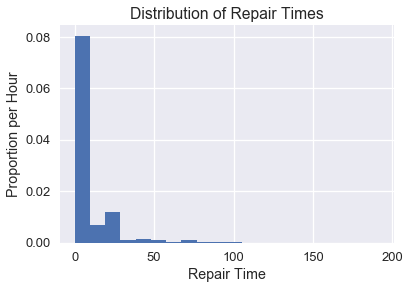

In [13]:
plt.hist(times, bins=20, normed=True);
plt.xlabel('Repair Time')
plt.ylabel('Proportion per Hour')
plt.title('Distribution of Repair Times');

We will take many samples from the population, compute a percentile confidence interval and a studentized confidence interval for each sample, and then compute the coverage for each. We will repeat this for varying sample sizes to see how the coverage of each method changes with sample size.

We can use `np.percentile` to compute the percentile confidence interval below:

In [14]:
def percentile_ci(sample, reps=bootstrap_reps, stat=stat):
    stats = bootstrap_stats(sample, reps, stat)
    return np.percentile(stats, [2.5, 97.5])

In [15]:
np.random.seed(0)
sample = take_sample(n=10)
percentile_ci(sample)

array([ 4.54, 29.56])

To do the studentized bootstrap, we need a lot more code:

In [16]:
def studentized_stats(sample, reps=bootstrap_reps, stat=stat):
    '''
    Computes studentized test statistics for the provided sample.
    
    Returns the studentized test statistics and the SD of the
    resample test statistics.
    '''
    # Bootstrap the sample and compute \tilde \theta values
    resamples = resample(sample, reps)
    resample_stats = stat(resamples, axis=1)
    resample_sd = np.std(resample_stats)
    
    # Compute SE of \tilde \theta.
    # Since we're estimating the sample mean, we can use the formula.
    # Without the formula, we would have to do a second level bootstrap here.
    resample_std_errs = np.std(resamples, axis=1) / np.sqrt(len(sample))
    
    # Compute studentized test statistics (q values)
    sample_stat = stat(sample)
    t_statistics = (resample_stats - sample_stat) / resample_std_errs
    return t_statistics, resample_sd
 
def studentized_ci(sample, reps=bootstrap_reps, stat=stat):
    '''
    Computes 95% studentized bootstrap CI
    '''
    t_statistics, resample_sd = studentized_stats(sample, reps, stat)
    lower, upper = np.percentile(t_statistics, [2.5, 97.5])
    
    sample_stat = stat(sample)
    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)

In [17]:
np.random.seed(0)
sample = take_sample(n=10)
studentized_ci(sample)

(4.499166906400612, 59.03291210887363)

Now that everything is written out, we can compare the coverages of the two methods as the sample size increases from 4 to 100.

In [18]:
def coverage(cis, parameter=theta):
    return (
        np.count_nonzero([lower < parameter < upper for lower, upper in cis])
        / len(cis)
    )

In [19]:
def run_trials(sample_sizes):
    np.random.seed(0)
    percentile_coverages = []
    studentized_coverages = []
    
    for n in sample_sizes:
        samples = [take_sample(n) for _ in range(samples_from_pop)]
        percentile_cis = [percentile_ci(sample) for sample in samples]
        studentized_cis = [studentized_ci(sample) for sample in samples]
        
        percentile_coverages.append(coverage(percentile_cis))
        studentized_coverages.append(coverage(studentized_cis))
    return pd.DataFrame({
        'percentile': percentile_coverages,
        'studentized': studentized_coverages,
    }, index=sample_sizes)

In [20]:
%%time

trials = run_trials(np.arange(4, 101, 2))

CPU times: user 1min 52s, sys: 1.08 s, total: 1min 53s
Wall time: 1min 57s


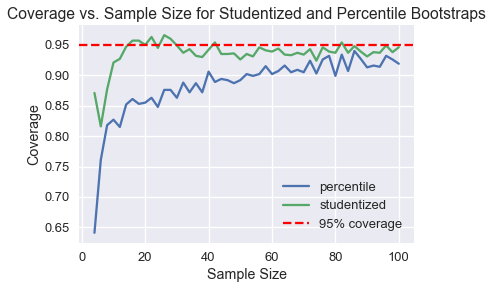

In [21]:
trials.plot()
plt.axhline(0.95, c='red', linestyle='--', label='95% coverage')
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Coverage')
plt.title('Coverage vs. Sample Size for Studentized and Percentile Bootstraps');

As we can see, the studentized bootstrap has a much better coverage at smaller sample sizes.

## Summary

The studentized bootstrap for the most part is better than the percentile bootstrap, especially if we only have a small sample to start with. We generally want to use this method when the sample size is small or when the original data is skewed. The main drawback is its computation time, which is further magnified if $SE(\tilde\theta)$ is not easy to compute.